# Machine Learning Model Building

In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import random 
import pickle 

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, make_scorer
from sklearn.feature_selection import RFE
from sklearn.datasets import make_regression

import xgboost as xgb
from xgboost import XGBRegressor

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

from functions.models import plot_feature_importance, plot_predicted_vs_actual

In [2]:
df = pd.read_csv('data/clean/cleaned_parkrun_no_outliers.csv')


## Process DataFrame into format for models

Does the following processing:
- Converts age groups to number
- Converts gender to 1/0 for Male/Female
- Drops null value columns
- Adds Days_since_first_parkrun column
- Removes unnecessary columns
- Creates time_change_index column as column to train for

In [3]:
def process_parkrun_data_for_models(df):
    """
    Preprocess the parkrun data from a CSV file.

    Parameters:
    - df: The cleaned dataframe

    Returns:
    - pd.DataFrame: Preprocessed DataFrame.
    """
    # Default age group mapping if none is provided

    age_group_map = {
        '18-19': 19,
        '20-24': 22,
        '25-29': 27,
        '30-34': 32,
        '35-39': 37,
        '40-44': 42,
        '45-49': 47,
        '50-54': 52,
        '55-59': 57,
        '60-64': 62,
        '65-69': 67,
        '70-74': 72
    }
    
    # Convert 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Map 'Age_group' to numeric values
    df['Age_group_numeric'] = df['Age_group'].map(age_group_map)
    
    # Calculate the first parkrun date for each runner
    df['first_parkrun_date'] = df.groupby('Runner_id')['Date'].transform('min')
    
    # Calculate days since the first parkrun
    df['Days_since_first_parkrun'] = (df['Date'] - df['first_parkrun_date']).dt.days
    
    # Map gender to binary values
    df['Male'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
    
    # Drop rows with missing values
    df = df.dropna()
    
    return df

In [7]:
df = process_parkrun_data_for_models(df)
df['time_change_index'] = df['Time_in_minutes'] / df['prev_run_time']

## Splits data for model training

In [9]:
# Drop the target and non-numeric columns
X = df[['temperature', 'windspeed', 'precipitation',
       'Appearance_Instance', 'Days_since_last_parkrun',
       'prev_run_time', 'prev_PB', 'avg_prev_run_times',
       'Age_group_numeric', 'Days_since_first_parkrun',
       'Male']]
y = df['time_change_index']


In [13]:
# Step 1: Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Step 2: Initialize MinMaxScaler
scaler = MinMaxScaler()

# Step 3: Normalize the training data
X_train_norm = scaler.fit_transform(X_train)

# Scales the test data using the same scaler
X_test_norm = scaler.transform(X_test)

# Save scaler as a pickle file to use
with open('models/to_use/minmax_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Convert the normalized data back to DataFrame
X_train_norm_df = pd.DataFrame(X_train_norm, columns=X.columns)
X_test_norm_df = pd.DataFrame(X_test_norm, columns=X.columns)

### Defines evaluation functions

In [ ]:
def plot_feature_importance(model, feature_names, title):
    """
    Function to plot feature importance of a trained model, sorted from most to least significant.
    
    Parameters:
    model: Trained model (e.g., RandomForestRegressor)
    feature_names: List of feature names
    title: Title for the plot
    
    Returns:
    feature_importances
    """
    # Extract feature importances
    feature_importances = model.feature_importances_
    
    # Sort features by importance in descending order
    sorted_indices = np.argsort(feature_importances)[::-1]
    sorted_feature_importances = feature_importances[sorted_indices]
    sorted_feature_names = np.array(feature_names)[sorted_indices]
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_feature_names, sorted_feature_importances, color='skyblue')
    plt.xscale('log')  # Use log scale for better visualization
    plt.xlabel('Feature Importance')
    plt.title(f'{title} Feature Importances (Sorted)')
    plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
    plt.tight_layout()
    plt.show()
    
    return sorted_feature_importances

def plot_predicted_vs_actual(y_test, y_pred, title):
    """
    Function to plot scatter plot of predicted vs actual values.
    
    Parameters:
    y_test: Actual target values
    y_pred: Predicted target values
    
    Returns:
    None
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Line for perfect prediction
    
    plt.xlabel('Actual Time Change Index')
    plt.ylabel('Predicted Time Change Index')
    plt.title(f'{title} Scatter Plot: Predicted vs Actual Time Change Index')
    plt.show()

    # Calculate y_test_actual and y_pred_actual
    y_test_actual = y_test * X_test['prev_run_time'].values
    
    # Calculate y_pred_actual
    y_pred_actual = y_pred * X_test['prev_run_time'].values

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_actual, y_pred_actual, color='blue', alpha=0.5)
    plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], color='red', linestyle='--')  # Line for perfect prediction
    
    plt.xlabel('Actual Time (mins)')
    plt.ylabel('Predicted Time (mins)')
    plt.title(f'{title} Scatter Plot: Predicted vs Actual Run Time')
    plt.show()

def score_vs_actual(y_test, y_pred):
    """
    Function to plot scatter plot of predicted vs actual values.
    
    Parameters:
    y_test: Actual target values
    y_pred: Predicted target values
    
    Returns:
    None
    """

    # Calculate y_test_actual and y_pred_actual
    y_test_actual = y_test * X_test['prev_run_time'].values
    
    # Calculate y_pred_actual
    y_pred_actual = y_pred * X_test['prev_run_time'].values
    rmse = root_mean_squared_error(y_test_actual, y_pred_actual)
    r2 = r2_score(y_test_actual, y_pred_actual)
    
    print(f'Root Mean Squared Error: {rmse.round(3)}')
    print(f'R-squared: {r2.round(3)}')

    return y_test_actual, y_pred_actual

## Build initial models

### Random Forest:

In [19]:
# Initialize and train Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train_norm_df, y_train)


RandomForestRegressor(random_state=0)

In [20]:

with open('models/time_change_index/rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

# Predict on test set
y_pred_rf = rf.predict(X_test_norm_df)

# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f'Root Mean Squared Error: {rmse.round(3)}')
print(f'R-squared: {r2.round(3)}')

Root Mean Squared Error: 0.06
R-squared: 0.332


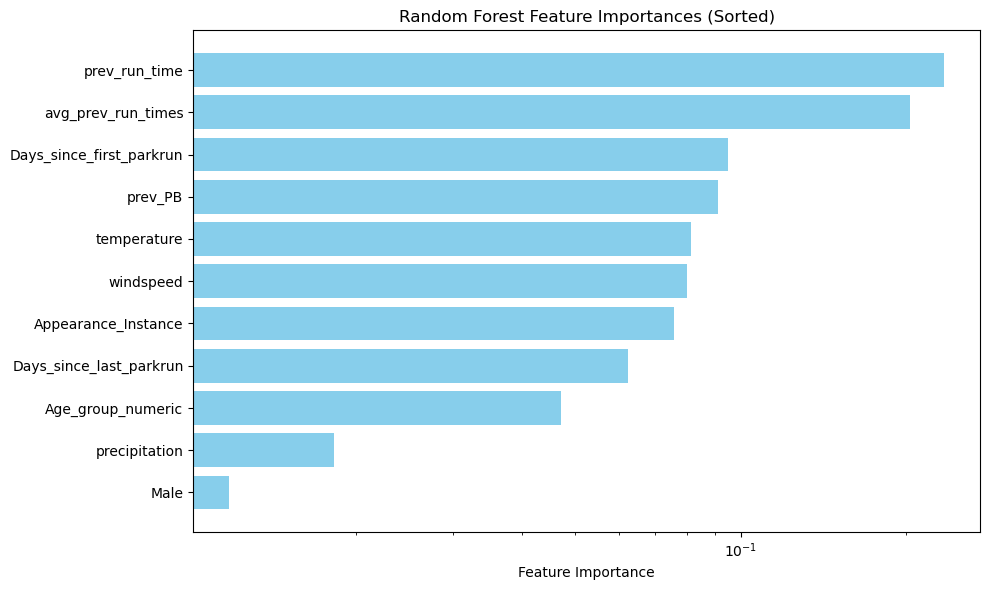

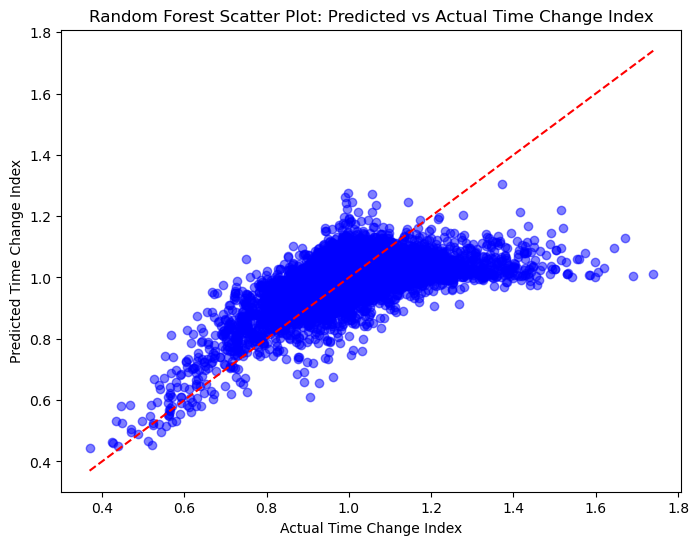

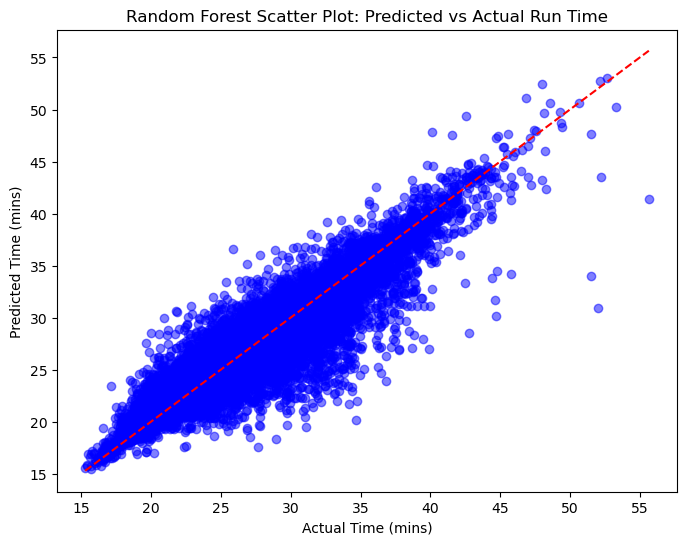

Root Mean Squared Error: 1.599
R-squared: 0.882


(76343     30.88
 42796     21.85
 64295     22.42
 142038    22.32
 28447     26.75
           ...  
 97253     32.27
 128997    20.65
 24894     31.10
 145878    27.13
 58003     23.73
 Name: time_change_index, Length: 30753, dtype: float64,
 array([30.55370149, 22.57276819, 21.77267031, ..., 30.28306825,
        25.10182003, 25.16876378]))

In [21]:
# Call functions to visualize feature importance and predicted vs actual
rf_features = plot_feature_importance(rf, X_train_norm_df.columns, 'Random Forest')
plot_predicted_vs_actual(y_test, y_pred_rf, 'Random Forest')
score_vs_actual(y_test, y_pred_rf)

### Linear Regression:

In [22]:
# Initialize and train Linear Regression model
lr = LinearRegression()
lr.fit(X_train_norm_df, y_train)

with open('models/time_change_index/linear_regression_model.pkl', 'wb') as f:
    pickle.dump(lr, f)

# Predict on test set
y_pred_lr = lr.predict(X_test_norm_df)

# Evaluate the model
rmse_lr = root_mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f'Linear Regression - RMSE: {rmse_lr.round(3)}')
print(f'Linear Regression - R-squared: {r2_lr.round(3)}')


Linear Regression - RMSE: 0.063
Linear Regression - R-squared: 0.285


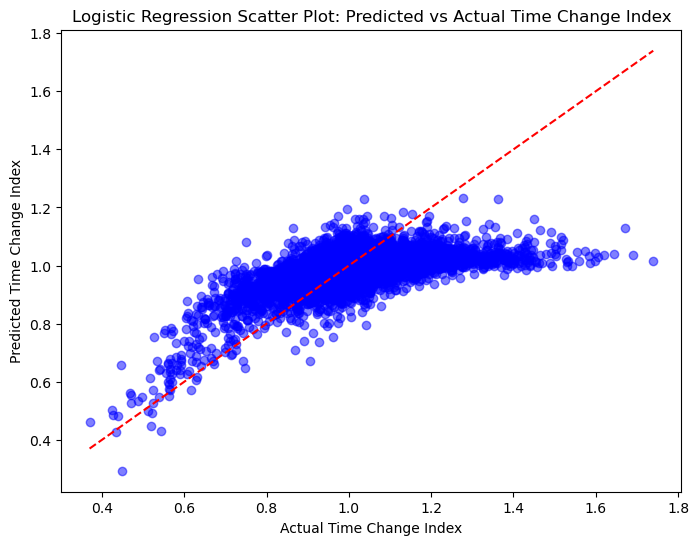

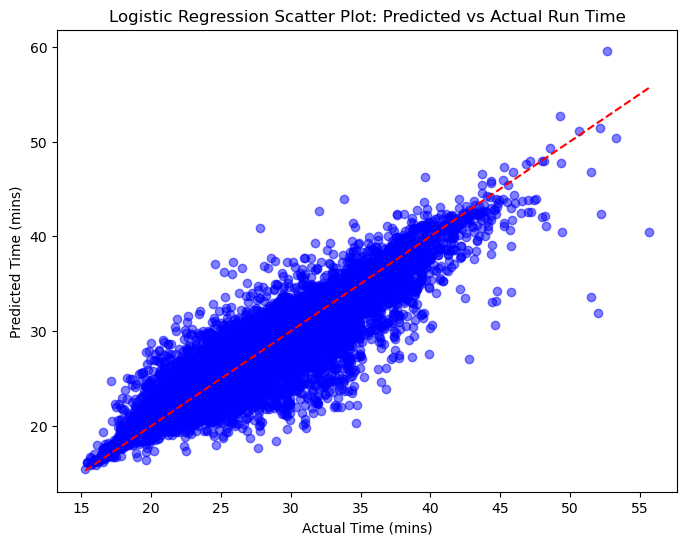

Root Mean Squared Error: 1.679
R-squared: 0.869


(76343     30.88
 42796     21.85
 64295     22.42
 142038    22.32
 28447     26.75
           ...  
 97253     32.27
 128997    20.65
 24894     31.10
 145878    27.13
 58003     23.73
 Name: time_change_index, Length: 30753, dtype: float64,
 array([30.86700807, 22.14809639, 21.99648272, ..., 30.41768155,
        25.18836631, 23.85598326]))

In [23]:
# Visualize results
plot_predicted_vs_actual(y_test, y_pred_lr, 'Logistic Regression')
score_vs_actual(y_test, y_pred_lr)

### Gradient Boosting Regressor:

In [24]:
# Initialize and train Gradient Boosting model
gb = GradientBoostingRegressor(n_estimators=100, random_state=0)
gb.fit(X_train_norm_df, y_train)

with open('models/time_change_index/gradient_boosting_model.pkl', 'wb') as f:
    pickle.dump(gb, f)

# Predict on test set
y_pred_gb = gb.predict(X_test_norm_df)

# Evaluate the model
rmse_gb = root_mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f'Gradient Boosting - RMSE: {rmse_gb.round(3)}')
print(f'Gradient Boosting - R-squared: {r2_gb.round(3)}')


Gradient Boosting - RMSE: 0.062
Gradient Boosting - R-squared: 0.309


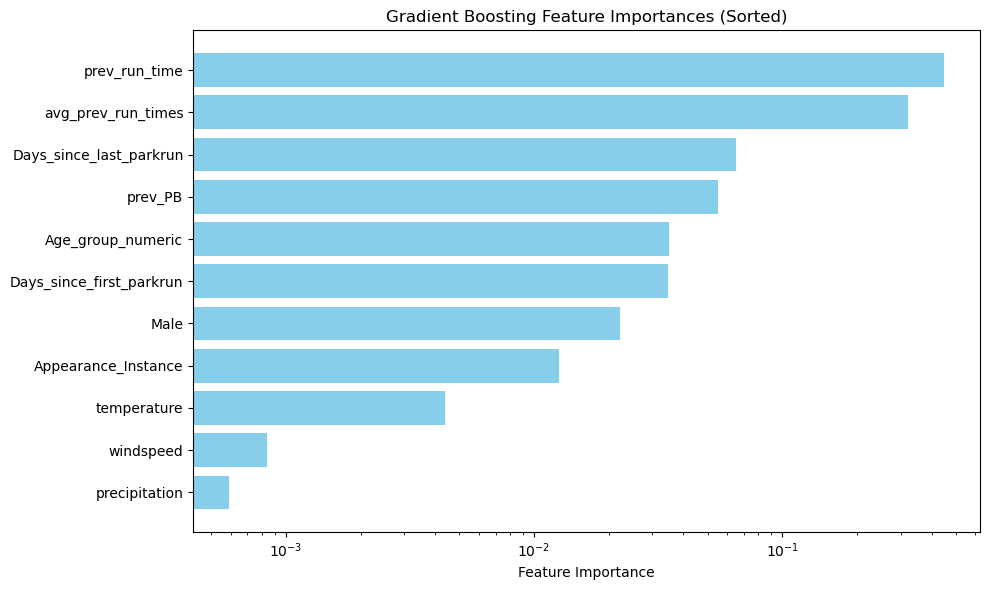

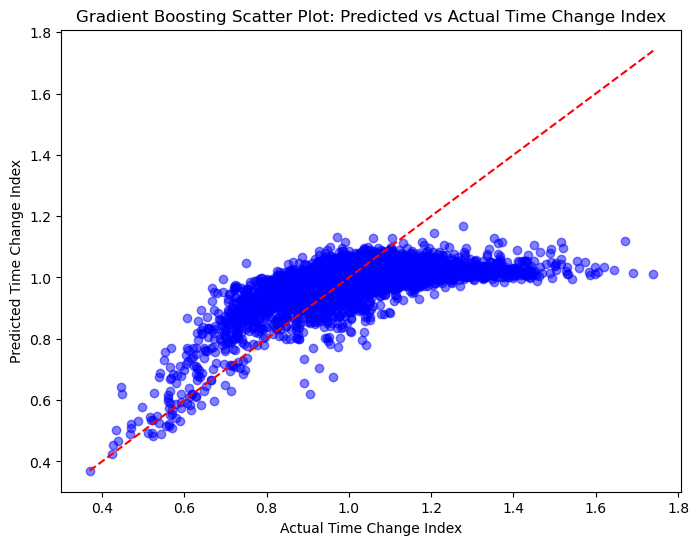

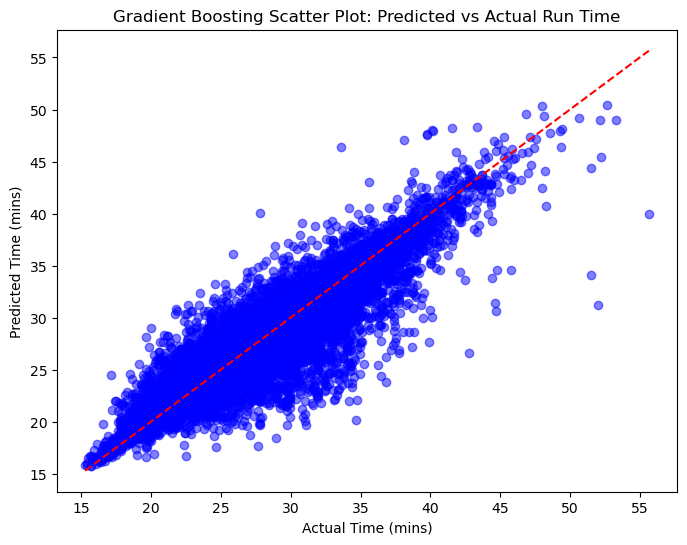

Root Mean Squared Error: 1.638
R-squared: 0.876


(76343     30.88
 42796     21.85
 64295     22.42
 142038    22.32
 28447     26.75
           ...  
 97253     32.27
 128997    20.65
 24894     31.10
 145878    27.13
 58003     23.73
 Name: time_change_index, Length: 30753, dtype: float64,
 array([30.65224908, 22.53554582, 22.10153524, ..., 30.13505722,
        25.41034044, 24.61982509]))

In [25]:
# Visualize results
gb_features = plot_feature_importance(gb, X_train_norm_df.columns, 'Gradient Boosting')
plot_predicted_vs_actual(y_test, y_pred_gb, 'Gradient Boosting')
score_vs_actual(y_test, y_pred_gb)

### XGB Regressor:

In [26]:
# Initialize and train XGBoost model
xg = xgb.XGBRegressor(n_estimators=100, random_state=0)
xg.fit(X_train_norm_df, y_train)

with open('models/time_change_index/xgb_model.pkl', 'wb') as f:
    pickle.dump(xg, f)

# Predict on test set
y_pred_xg = xg.predict(X_test_norm_df)

# Evaluate the model
rmse_xg = root_mean_squared_error(y_test, y_pred_xg)
r2_xg = r2_score(y_test, y_pred_xg)

print(f'XGBoost - RMSE: {rmse_xg.round(3)}')
print(f'XGBoost - R-squared: {r2_xg.round(3)}')


XGBoost - RMSE: 0.06
XGBoost - R-squared: 0.335


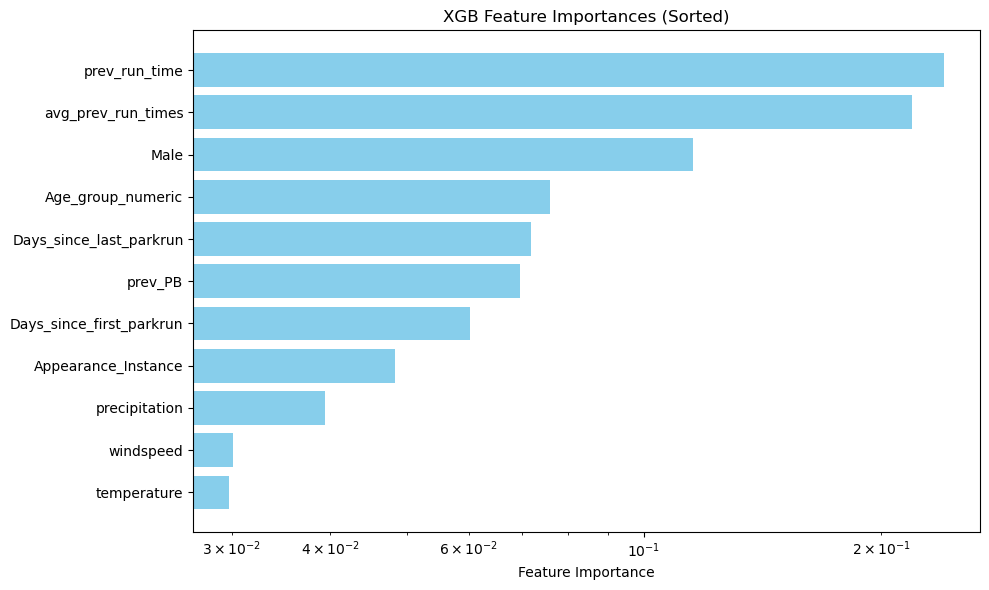

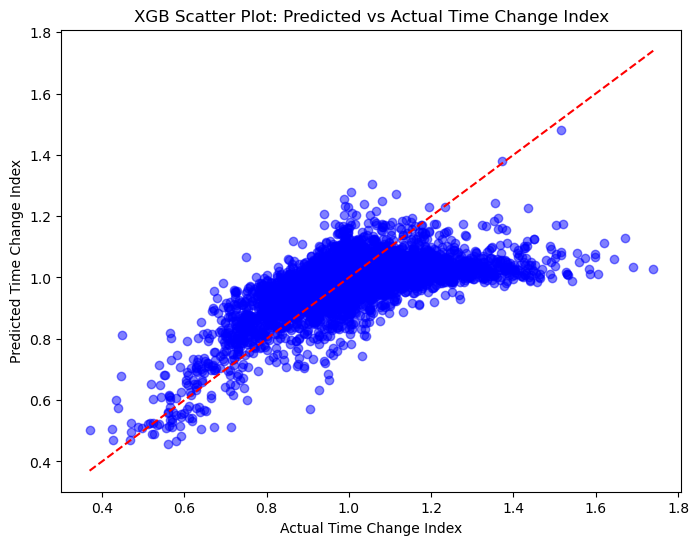

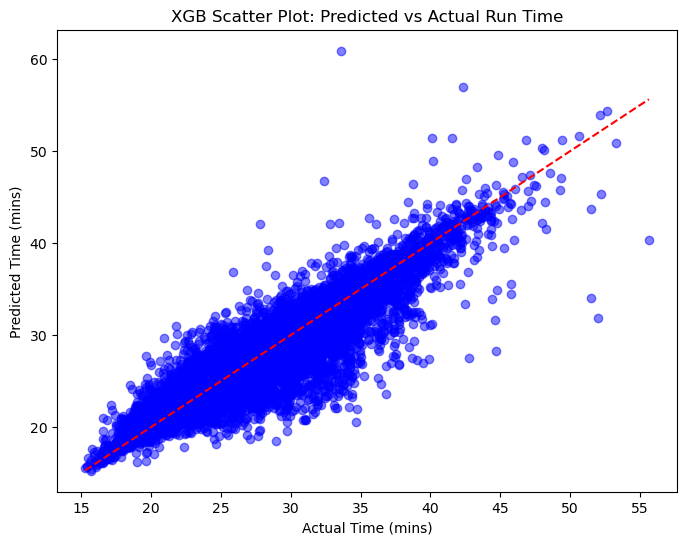

Root Mean Squared Error: 1.616
R-squared: 0.879


(76343     30.88
 42796     21.85
 64295     22.42
 142038    22.32
 28447     26.75
           ...  
 97253     32.27
 128997    20.65
 24894     31.10
 145878    27.13
 58003     23.73
 Name: time_change_index, Length: 30753, dtype: float64,
 array([30.51684737, 23.06007328, 22.03427163, ..., 30.10794743,
        25.21445598, 24.32355376]))

In [27]:
# Visualize results
xg_features = plot_feature_importance(xg, X_train_norm_df.columns, 'XGB')
plot_predicted_vs_actual(y_test, y_pred_xg, 'XGB')
score_vs_actual(y_test, y_pred_xg)

### K-Nearest Neighbours:

In [28]:
# Initialize and train KNN model
knn = KNeighborsRegressor(n_neighbors=7, weights='distance')
knn.fit(X_train_norm_df, y_train)

# Predict on test set
y_pred_knn = knn.predict(X_test_norm_df)

with open('models/time_change_index/knn_model.pkl', 'wb') as f:
    pickle.dump(knn, f)

# Evaluate the model
rmse_knn = root_mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f'KNN - RMSE: {rmse_knn.round(3)}')
print(f'KNN - R-squared: {r2_knn.round(3)}')


KNN - RMSE: 0.07
KNN - R-squared: 0.103


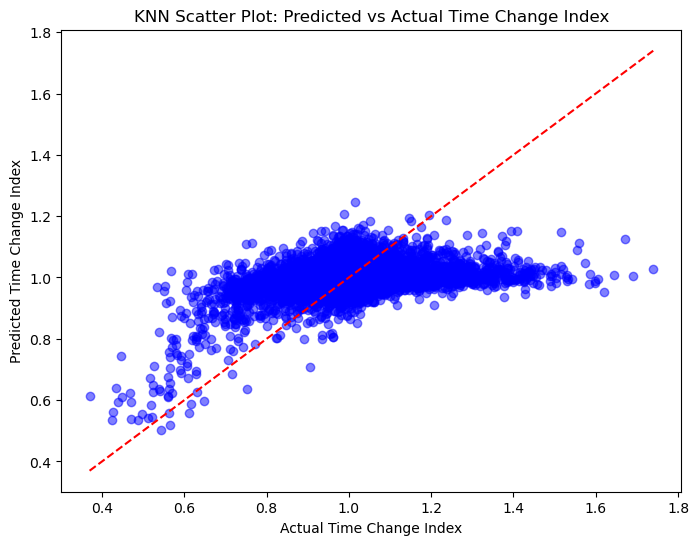

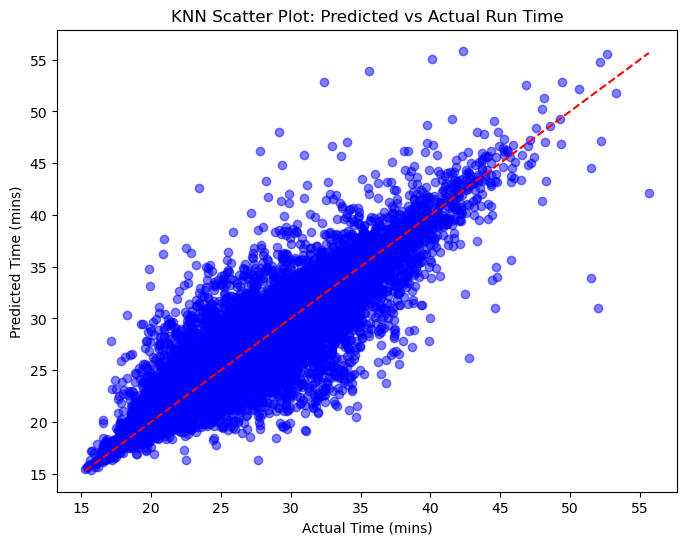

Root Mean Squared Error: 1.928
R-squared: 0.828


(76343     30.88
 42796     21.85
 64295     22.42
 142038    22.32
 28447     26.75
           ...  
 97253     32.27
 128997    20.65
 24894     31.10
 145878    27.13
 58003     23.73
 Name: time_change_index, Length: 30753, dtype: float64,
 array([30.41026942, 23.69233521, 22.37453086, ..., 31.31364157,
        24.92838104, 24.26372964]))

In [29]:
# Visualize results
plot_predicted_vs_actual(y_test, y_pred_knn, 'KNN')
score_vs_actual(y_test, y_pred_knn)

### Evaluate model performance:

In [30]:
print(f'KNN - RMSE: {rmse_knn.round(3)}')
print(f'KNN - R-squared: {r2_knn.round(3)}')
print('')
print(f'XGBoost - RMSE: {rmse_xg.round(3)}')
print(f'XGBoost - R-squared: {r2_xg.round(3)}')
print('')
print(f'Gradient Boosting - RMSE: {rmse_gb.round(3)}')
print(f'Gradient Boosting - R-squared: {r2_gb.round(3)}')
print('')
print(f'Linear Regression - RMSE: {rmse_lr.round(3)}')
print(f'Linear Regression - R-squared: {r2_lr.round(3)}')
print('')
print(f'Random Forest - RMSE: {rmse.round(3)}')
print(f'Random Forest - R-squared: {r2.round(3)}')

KNN - RMSE: 0.07
KNN - R-squared: 0.103

XGBoost - RMSE: 0.06
XGBoost - R-squared: 0.335

Gradient Boosting - RMSE: 0.062
Gradient Boosting - R-squared: 0.309

Linear Regression - RMSE: 0.063
Linear Regression - R-squared: 0.285

Random Forest - RMSE: 0.06
Random Forest - R-squared: 0.332


## Optimisation

In [33]:
def objective(trial):
    # Define hyperparameter space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10)
    }

    # Create and evaluate the model
    model = XGBRegressor(**params, random_state=0)
    
    # Use 'r2' directly as the scoring parameter
    scores = cross_val_score(model, X_train_norm_df, y_train, cv=5, scoring='r2')
    
    # Return the mean score
    return np.mean(scores)

In [35]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Adjust n_trials as needed

# Best parameters and score
print("Best Parameters:", study.best_params)
print("Best R2:", study.best_value)

[I 2024-12-13 17:13:01,589] A new study created in memory with name: no-name-c52e4120-e79f-4cf9-ab02-d585c836ba30
[I 2024-12-13 17:13:03,322] Trial 0 finished with value: 0.2597512444635135 and parameters: {'n_estimators': 184, 'max_depth': 9, 'learning_rate': 0.11743591743274884, 'subsample': 0.6829281449424185, 'colsample_bytree': 0.9489018413997019, 'gamma': 0.5709075573038852, 'reg_alpha': 3.7862245486438284, 'reg_lambda': 6.10128204794167}. Best is trial 0 with value: 0.2597512444635135.
[I 2024-12-13 17:13:05,525] Trial 1 finished with value: 0.19529009851239215 and parameters: {'n_estimators': 287, 'max_depth': 3, 'learning_rate': 0.1075904948732992, 'subsample': 0.7162100817987175, 'colsample_bytree': 0.9537864870216174, 'gamma': 1.566465668902635, 'reg_alpha': 7.959063636703773, 'reg_lambda': 4.35874596967364}. Best is trial 0 with value: 0.2597512444635135.
[I 2024-12-13 17:13:07,254] Trial 2 finished with value: 0.14508904328391137 and parameters: {'n_estimators': 216, 'max_

Best Parameters: {'n_estimators': 183, 'max_depth': 6, 'learning_rate': 0.04516132408071326, 'subsample': 0.9916781210726074, 'colsample_bytree': 0.8931742173389134, 'gamma': 0.01828746744008923, 'reg_alpha': 5.602805454274197, 'reg_lambda': 1.6809856197317536}
Best R2: 0.32525932976717603


Training RMSE: 0.060
Training R-squared: 0.344

Test RMSE: 0.061
Test R-squared: 0.324


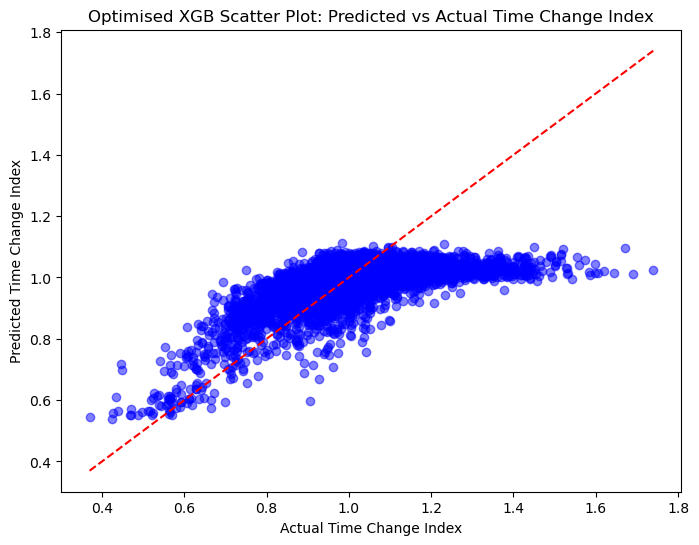

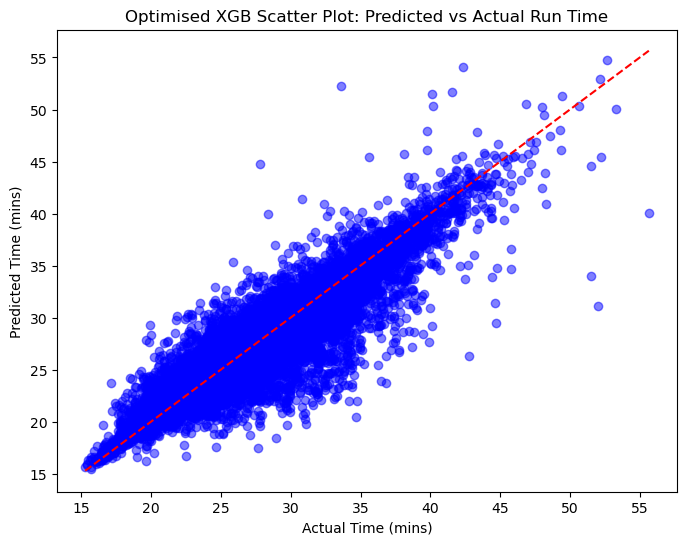

Root Mean Squared Error: 1.627
R-squared: 0.877


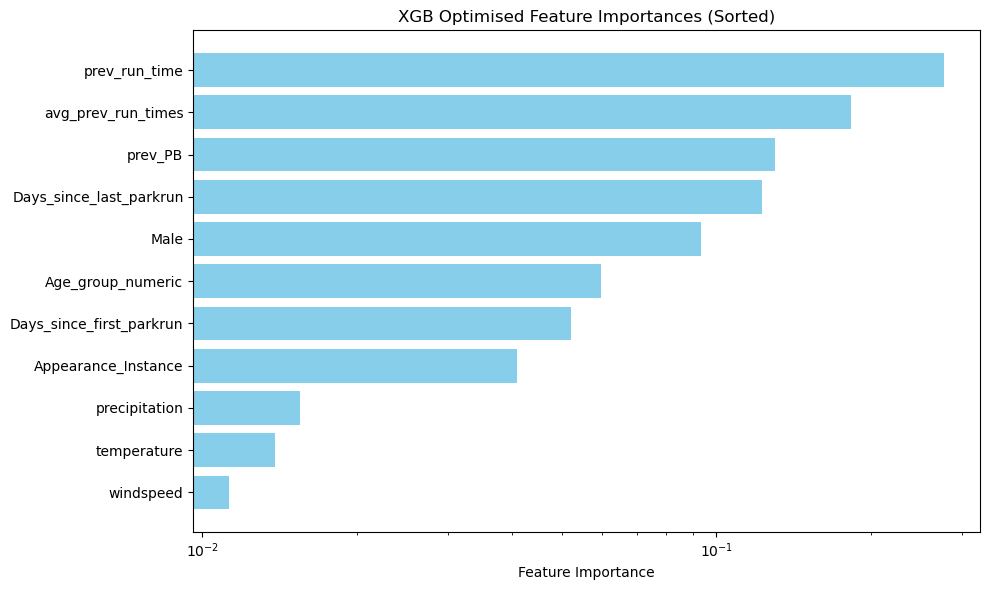

In [36]:
# Train final model with best parameters
best_params = study.best_params
best_xgb_model = XGBRegressor(**best_params, random_state=0)
best_xgb_model.fit(X_train_norm_df, y_train)

with open('models/time_change_index/optimised/xgb_opt_model.pkl', 'wb') as f:
    pickle.dump(best_xgb_model, f)

# Evaluate on test data
y_pred_opt_test = best_xgb_model.predict(X_test_norm_df)
rmse_opt_test = root_mean_squared_error(y_test, y_pred_opt_test)
r2_opt_test = r2_score(y_test, y_pred_opt_test)

# Evaluate on training data
y_pred_opt_train = best_xgb_model.predict(X_train_norm_df)
rmse_opt_train = root_mean_squared_error(y_train, y_pred_opt_train)
r2_opt_train = r2_score(y_train, y_pred_opt_train)

# Print results
print(f"Training RMSE: {rmse_opt_train:.3f}")
print(f"Training R-squared: {r2_opt_train:.3f}")
print("")
print(f"Test RMSE: {rmse_opt_test:.3f}")
print(f"Test R-squared: {r2_opt_test:.3f}")

plot_predicted_vs_actual(y_test, y_pred_opt_test, 'Optimised XGB')
score_vs_actual(y_test, y_pred_opt_test)
best_xgb_features = plot_feature_importance(best_xgb_model, X_train_norm_df.columns, 'XGB Optimised')

This is the model that we end up using

plot_optimization_history(study).show()
plot_param_importances(study).show()

## Recursive feature elimination

In [38]:
# Use RFE for feature selection
rfe = RFE(estimator=best_xgb_model, n_features_to_select=5)

# Fit the RFE model and track progress manually
num_features = X_train_norm_df.shape[1]  # Total number of features
print(f"Starting RFE with {num_features} features. Progress will be displayed...")

# Fit the RFE model and track iterations
for i in range(num_features, 0, -1):  # RFE reduces features, start from the full set
    rfe.n_features_to_select = i  # Reduce the number of features in each iteration
    rfe.fit(X_train_norm_df, y_train)
    
    # After each iteration, print the progress
    print(f"RFE iteration {num_features - i + 1}/{num_features}: {i} features remaining.")


# Get selected features and their rankings
selected_features = rfe.support_  # Boolean mask of selected features
feature_ranking = rfe.ranking_    # Feature ranking (1 means selected)

# Print results
print("Selected Features (True = Selected):", selected_features)
print("Feature Ranking:", feature_ranking)

Starting RFE with 11 features. Progress will be displayed...
RFE iteration 1/11: 11 features remaining.
RFE iteration 2/11: 10 features remaining.
RFE iteration 3/11: 9 features remaining.
RFE iteration 4/11: 8 features remaining.
RFE iteration 5/11: 7 features remaining.
RFE iteration 6/11: 6 features remaining.
RFE iteration 7/11: 5 features remaining.
RFE iteration 8/11: 4 features remaining.
RFE iteration 9/11: 3 features remaining.
RFE iteration 10/11: 2 features remaining.
RFE iteration 11/11: 1 features remaining.
Selected Features (True = Selected): [False False False False False  True False False False False False]
Feature Ranking: [10 11  9  8  3  1  4  2  7  6  5]


In [39]:
ranked_columns = [(col, rank) for col, rank in zip(X_train_norm_df.columns, feature_ranking)]

ranked_columns = sorted(ranked_columns, key=lambda x: x[1])
ranked_columns

[('prev_run_time', 1),
 ('avg_prev_run_times', 2),
 ('Days_since_last_parkrun', 3),
 ('prev_PB', 4),
 ('Male', 5),
 ('Days_since_first_parkrun', 6),
 ('Age_group_numeric', 7),
 ('Appearance_Instance', 8),
 ('precipitation', 9),
 ('temperature', 10),
 ('windspeed', 11)]

### Test and train models with different numbers of features

In [40]:
def optimize_and_train_model(sorted_features, X_train_norm_df, X_test_norm_df, y_train, y_test, model_save_path, top_n=6, n_trials=50):
    """
    Function to optimize an XGBoost model using Optuna, train it with the best parameters, 
    and evaluate it on training and test sets.

    Parameters:
    sorted_features: List of tuples containing feature names and their scores, sorted by importance.
    X_train_norm_df: DataFrame containing normalized training features.
    X_test_norm_df: DataFrame containing normalized test features.
    y_train: Training target variable.
    y_test: Test target variable.
    top_n: Number of top features to use for optimization. Default is 6.
    n_trials: Number of trials for Optuna optimization. Default is 50.
    model_save_path: Path to save the trained model.

    Returns:
    study: Optuna study object containing optimization results.
    best_model: Trained XGBoost model with the best parameters.
    """
    # Select top N features
    top_n_cols = [feature[0] for feature in sorted_features[:top_n]]
    filt_X_train_norm_df = X_train_norm_df[top_n_cols]
    filt_X_test_norm_df = X_test_norm_df[top_n_cols]

    # Define the objective function for Optuna
    def objective(trial):
        # Define hyperparameter space
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        }

        # Create and evaluate the model
        model = XGBRegressor(**params, random_state=0)
        scores = cross_val_score(
            model, filt_X_train_norm_df, y_train, 
            cv=5, scoring=make_scorer(root_mean_squared_error, greater_is_better=False)
        )
        return np.mean(scores)

    # Run the Optuna study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    # Train the final model with the best parameters
    best_params = study.best_params
    best_model = XGBRegressor(**best_params, random_state=0)
    best_model.fit(filt_X_train_norm_df, y_train)

    # Save the trained model
    with open(model_save_path, 'wb') as f:
        pickle.dump(best_model, f)

    # Evaluate on test data
    y_pred_test = best_model.predict(filt_X_test_norm_df)
    rmse_test = np.sqrt(np.mean((y_test - y_pred_test) ** 2))  # Root Mean Squared Error
    r2_test = r2_score(y_test, y_pred_test)

    # Evaluate on training data
    y_pred_train = best_model.predict(filt_X_train_norm_df)
    rmse_train = np.sqrt(np.mean((y_train - y_pred_train) ** 2))  # Root Mean Squared Error
    r2_train = r2_score(y_train, y_pred_train)

    # Print results
    print(f"Top {top_n} Features Used: {top_n_cols}")
    print("Best Parameters:", best_params)
    print("")
    print(f"Training RMSE: {rmse_train:.3f}")
    print(f"Training R-squared: {r2_train:.3f}")
    print("")
    print(f"Test RMSE: {rmse_test:.3f}")
    print(f"Test R-squared: {r2_test:.3f}")

    return study, best_model

In [41]:
study7, best_model7 = optimize_and_train_model(
    top_n=7,
    model_save_path="models/time_change_index/optimised/xgb_opt_7_features_model.pkl",
    sorted_features=ranked_columns,
    X_train_norm_df=X_train_norm_df,
    X_test_norm_df=X_test_norm_df,
    y_train=y_train,
    y_test=y_test,
    n_trials=20,    
)


[I 2024-12-13 17:14:15,358] A new study created in memory with name: no-name-ab6c707e-d510-4f7e-b254-b6ce26538060
[I 2024-12-13 17:14:16,058] Trial 0 finished with value: -0.06704955849868828 and parameters: {'n_estimators': 52, 'max_depth': 6, 'learning_rate': 0.03542870214914795, 'subsample': 0.855534978480225, 'colsample_bytree': 0.8281714348036409, 'gamma': 2.289373157554362, 'reg_alpha': 9.1107139302892, 'reg_lambda': 3.604054806788194}. Best is trial 0 with value: -0.06704955849868828.
[I 2024-12-13 17:14:16,787] Trial 1 finished with value: -0.06879784800852282 and parameters: {'n_estimators': 73, 'max_depth': 4, 'learning_rate': 0.06956730877329757, 'subsample': 0.6131664493860884, 'colsample_bytree': 0.9741843659475362, 'gamma': 4.205118715180312, 'reg_alpha': 6.9122726124592315, 'reg_lambda': 2.7464596402216745}. Best is trial 0 with value: -0.06704955849868828.
[I 2024-12-13 17:14:18,254] Trial 2 finished with value: -0.06599580926062441 and parameters: {'n_estimators': 195,

Top 7 Features Used: ['prev_run_time', 'avg_prev_run_times', 'Days_since_last_parkrun', 'prev_PB', 'Male', 'Days_since_first_parkrun', 'Age_group_numeric']
Best Parameters: {'n_estimators': 101, 'max_depth': 8, 'learning_rate': 0.11570798699886659, 'subsample': 0.9996060862013361, 'colsample_bytree': 0.6071797488127202, 'gamma': 0.004043876864705087, 'reg_alpha': 1.3048415162607316, 'reg_lambda': 8.781434369409638}

Training RMSE: 0.058
Training R-squared: 0.376

Test RMSE: 0.060
Test R-squared: 0.333


In [42]:

study8, best_model8 = optimize_and_train_model(
    top_n=8,
    model_save_path="models/time_change_index/optimised/xgb_opt_8_features_model.pkl",
    sorted_features=ranked_columns,
    X_train_norm_df=X_train_norm_df,
    X_test_norm_df=X_test_norm_df,
    y_train=y_train,
    y_test=y_test,
    n_trials=20,    
)

[I 2024-12-13 17:14:46,504] A new study created in memory with name: no-name-a10ef2bf-2b6c-4bc5-9087-5f34aefec0a0
[I 2024-12-13 17:14:48,119] Trial 0 finished with value: -0.06754191890307337 and parameters: {'n_estimators': 220, 'max_depth': 7, 'learning_rate': 0.19169807615091827, 'subsample': 0.7653143049183672, 'colsample_bytree': 0.9980450328794346, 'gamma': 3.7557828642794022, 'reg_alpha': 6.164435303767187, 'reg_lambda': 5.986533289500521}. Best is trial 0 with value: -0.06754191890307337.
[I 2024-12-13 17:14:49,590] Trial 1 finished with value: -0.06640498636125433 and parameters: {'n_estimators': 177, 'max_depth': 9, 'learning_rate': 0.020332148431377987, 'subsample': 0.969430101206222, 'colsample_bytree': 0.960684233161241, 'gamma': 2.24050642440495, 'reg_alpha': 9.285593335148969, 'reg_lambda': 1.443674354479193}. Best is trial 1 with value: -0.06640498636125433.
[I 2024-12-13 17:14:51,255] Trial 2 finished with value: -0.06380083796749807 and parameters: {'n_estimators': 16

Top 8 Features Used: ['prev_run_time', 'avg_prev_run_times', 'Days_since_last_parkrun', 'prev_PB', 'Male', 'Days_since_first_parkrun', 'Age_group_numeric', 'Appearance_Instance']
Best Parameters: {'n_estimators': 256, 'max_depth': 6, 'learning_rate': 0.04196376110957894, 'subsample': 0.6846254434281029, 'colsample_bytree': 0.6919004411409371, 'gamma': 0.062262734123327904, 'reg_alpha': 0.4807316880487402, 'reg_lambda': 0.6907225896128033}

Training RMSE: 0.060
Training R-squared: 0.344

Test RMSE: 0.061
Test R-squared: 0.323


In [43]:

study9, best_model9 = optimize_and_train_model(
    top_n=9,
    model_save_path="models/time_change_index/optimised/xgb_opt_9_features_model.pkl",
    sorted_features=ranked_columns,
    X_train_norm_df=X_train_norm_df,
    X_test_norm_df=X_test_norm_df,
    y_train=y_train,
    y_test=y_test,
    n_trials=20,    
)

[I 2024-12-13 17:15:31,967] A new study created in memory with name: no-name-4980f92e-551a-4e69-bc21-9c9a38cb0f6e
[I 2024-12-13 17:15:33,259] Trial 0 finished with value: -0.06779578538453093 and parameters: {'n_estimators': 114, 'max_depth': 4, 'learning_rate': 0.012641925638795912, 'subsample': 0.7381738314149263, 'colsample_bytree': 0.7620224515379981, 'gamma': 2.105391261289517, 'reg_alpha': 1.8689758056960237, 'reg_lambda': 7.578193908912625}. Best is trial 0 with value: -0.06779578538453093.
[I 2024-12-13 17:15:35,573] Trial 1 finished with value: -0.06631831547631757 and parameters: {'n_estimators': 254, 'max_depth': 3, 'learning_rate': 0.010926366976342831, 'subsample': 0.9930429804398339, 'colsample_bytree': 0.6272575610534762, 'gamma': 0.6855698716828312, 'reg_alpha': 9.764589572185834, 'reg_lambda': 1.9022275345993767}. Best is trial 1 with value: -0.06631831547631757.
[I 2024-12-13 17:15:36,821] Trial 2 finished with value: -0.06505718170843663 and parameters: {'n_estimator

Top 9 Features Used: ['prev_run_time', 'avg_prev_run_times', 'Days_since_last_parkrun', 'prev_PB', 'Male', 'Days_since_first_parkrun', 'Age_group_numeric', 'Appearance_Instance', 'precipitation']
Best Parameters: {'n_estimators': 71, 'max_depth': 10, 'learning_rate': 0.2870817187044736, 'subsample': 0.9100278253241556, 'colsample_bytree': 0.9894448062410074, 'gamma': 0.060250264270427456, 'reg_alpha': 0.06440617523763313, 'reg_lambda': 3.1180117294815943}

Training RMSE: 0.058
Training R-squared: 0.374

Test RMSE: 0.061
Test R-squared: 0.324


### Evaluate models at different feature numbers

In [44]:
def evaluate_model(model, feature_count, title, ranked_columns, X_train_norm_df, y_train, X_test_norm_df, y_test):
    # Select top N features based on sorted feature ranking
    top_n_cols = [feature[0] for feature in ranked_columns[:feature_count]]
    
    # Ensure columns are available in both training and test data
    X_train_selected = X_train_norm_df[top_n_cols]
    X_test_selected = X_test_norm_df[top_n_cols]  # Use the same columns for the test set
    
    # Predict on test data
    y_pred = model.predict(X_test_selected)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Predict on training data with selected features
    y_pred_train = model.predict(X_train_selected)
    rmse_train = root_mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    
    # Print results
    print(f"Training RMSE: {rmse_train:.3f}")
    print(f"Training R-squared: {r2_train:.3f}")
    print("")
    print(f"Test RMSE: {rmse:.3f}")
    print(f"Test R-squared: {r2:.3f}")
    
    # Plot predicted vs actual for test set
    plot_predicted_vs_actual(y_test, y_pred, title)
    score_vs_actual(y_test, y_pred)
    return best_xgb_features

Training RMSE: 0.058
Training R-squared: 0.376

Test RMSE: 0.060
Test R-squared: 0.333


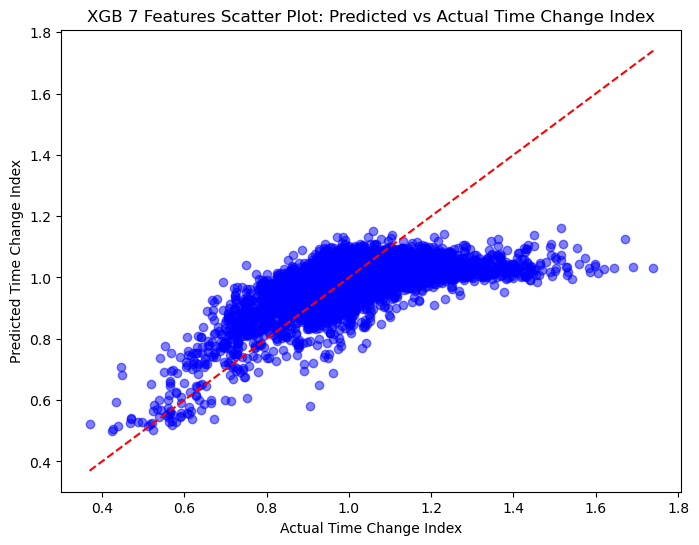

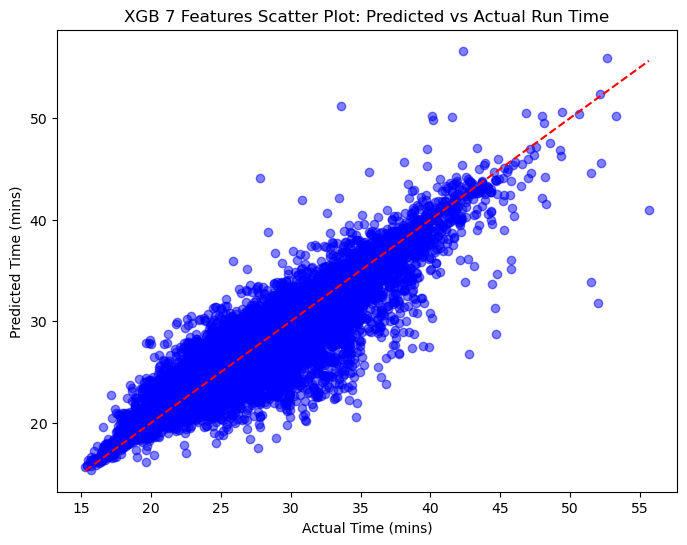

Root Mean Squared Error: 1.612
R-squared: 0.88


array([0.2776711 , 0.18271942, 0.13000269, 0.12276956, 0.09342454,
       0.05973505, 0.05218783, 0.04089103, 0.01549078, 0.01383954,
       0.01126838], dtype=float32)

In [45]:
evaluate_model(best_model7, 7, 'XGB 7 Features', ranked_columns, X_train_norm_df, y_train, X_test_norm_df, y_test)

Training RMSE: 0.060
Training R-squared: 0.344

Test RMSE: 0.061
Test R-squared: 0.323


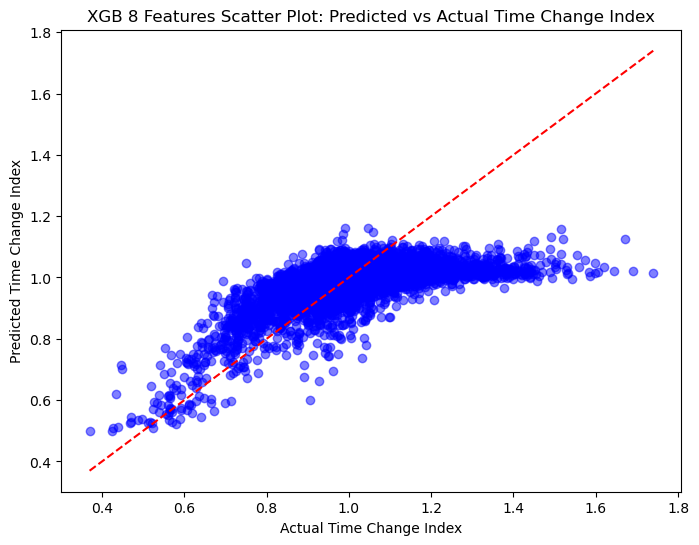

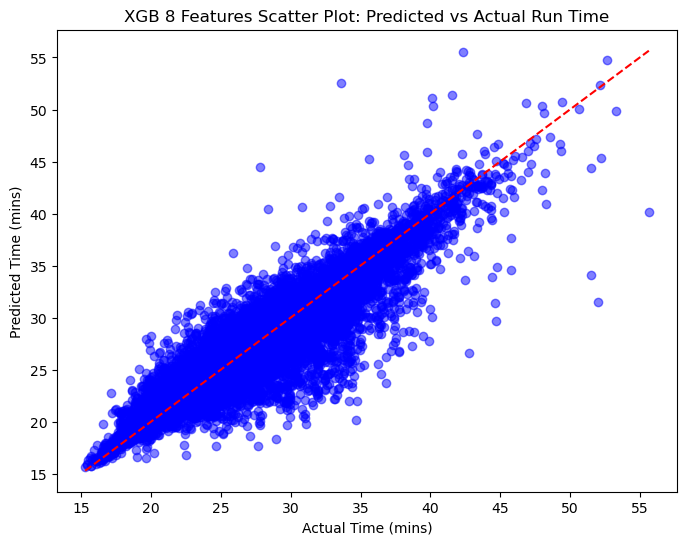

Root Mean Squared Error: 1.627
R-squared: 0.877


array([0.2776711 , 0.18271942, 0.13000269, 0.12276956, 0.09342454,
       0.05973505, 0.05218783, 0.04089103, 0.01549078, 0.01383954,
       0.01126838], dtype=float32)

In [46]:
evaluate_model(best_model8, 8, 'XGB 8 Features', ranked_columns, X_train_norm_df, y_train, X_test_norm_df, y_test)

Training RMSE: 0.058
Training R-squared: 0.374

Test RMSE: 0.061
Test R-squared: 0.324


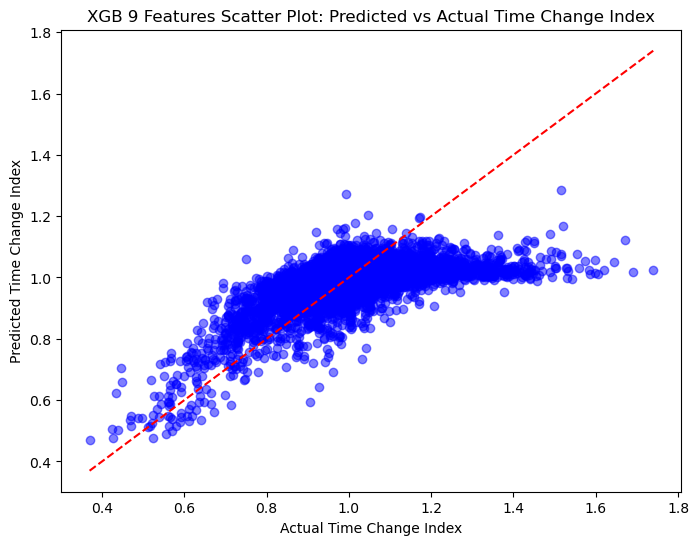

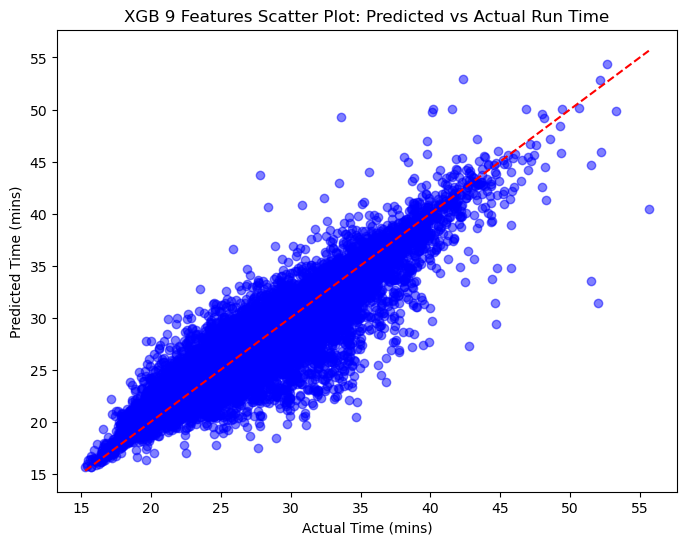

Root Mean Squared Error: 1.624
R-squared: 0.878


array([0.2776711 , 0.18271942, 0.13000269, 0.12276956, 0.09342454,
       0.05973505, 0.05218783, 0.04089103, 0.01549078, 0.01383954,
       0.01126838], dtype=float32)

In [47]:
evaluate_model(best_model9, 9, 'XGB 9 Features', ranked_columns, X_train_norm_df, y_train, X_test_norm_df, y_test)